# Определение выгодного тарифа для телеком компании

## Постановка задачи

Заказчиком является оператор мобильной связи, который специализируется на предоставлении услуг связи для клиентов.

Требуется на основе данных клиентов оператора сотовой связи проанализировать поведение клиентов и подготовить модель, которая бы могла предложить пользователям новый тариф: «Смарт» или «Ультра»

Проверка модели должна осуществлятся на метрике accuracy. На тестовой выборке данная метрика должна быть не менее 0,75.

## Описание данных

- **users_behavior.csv** - данные, хранящие в поведение клиентов

**1) Подготовка**

- Узнать размер данных

**2) Анализ**
- Проанализировать распределение параметров и целевого признака

**3) Обучение моделей**

- Выделение целевого признака
- Разделение данных на обучающую и тестовую выборку
- Подбор наилучших параметров методом кросс-валидации
- Отбор наилучшей модели

**4) Тестирование лучшей модели**

- Протестировать модель на тестовой выборке с параметрами, которые были у обучающей модели
- Сравнить метрику обучающей и тестовой модели
- Проверить на сколько лучше или хуже полученная метрика в сравнении с требуемой

## 1 Подготовка

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.dummy import DummyClassifier


In [2]:
df = pd.read_csv(r'C:\Users\Илья\Downloads\users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.shape

(3214, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## Вывод

- Размер данных 3214 на 5

## 2 Анализ

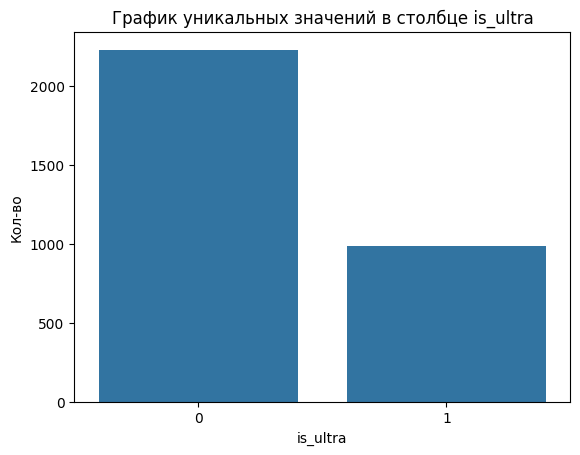

In [5]:
sns.countplot(x='is_ultra', data=df)
plt.title('График уникальных значений в столбце is_ultra')
plt.ylabel('Кол-во')
plt.show()


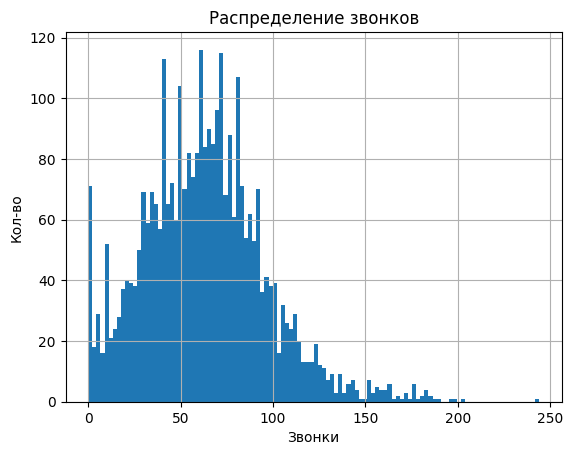

In [6]:
df['calls'].hist(bins=110)
plt.title('Распределение звонков')
plt.xlabel('Звонки')
plt.ylabel('Кол-во');

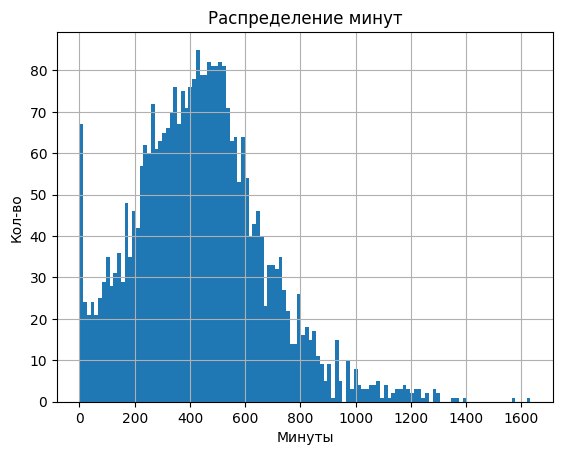

In [7]:
df['minutes'].hist(bins=120)
plt.title('Распределение минут')
plt.xlabel('Минуты')
plt.ylabel('Кол-во');

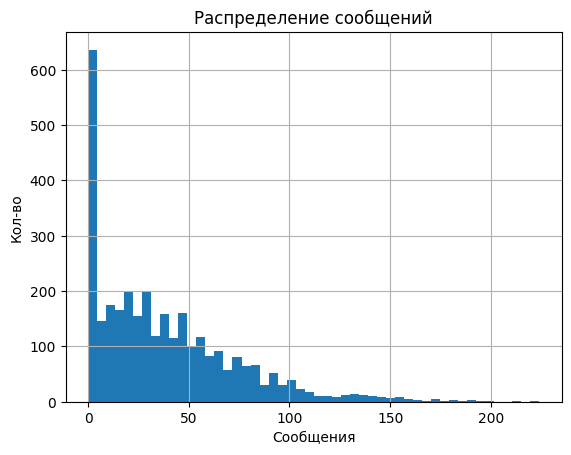

In [8]:
df['messages'].hist(bins=50)
plt.title('Распределение сообщений')
plt.xlabel('Сообщения')
plt.ylabel('Кол-во');

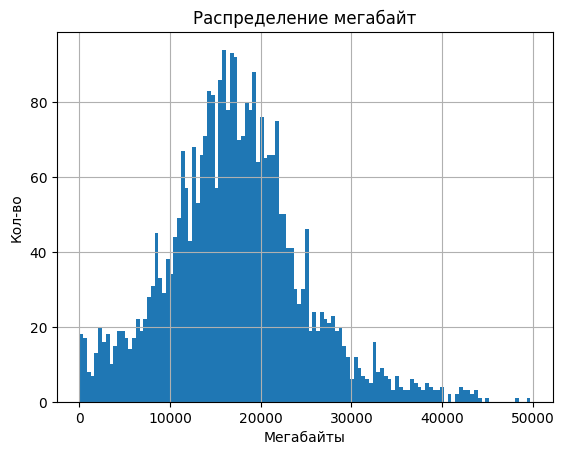

In [9]:
df['mb_used'].hist(bins=120)
plt.title('Распределение мегабайт')
plt.xlabel('Мегабайты')
plt.ylabel('Кол-во');

## Вывод

- Заметно преобладание тарифа **Смарт** примерно в два раза. Скорее всего это из за того, что при поиощи данного тарифа можно закрыт базовые портебности в связи
- Заметно, что чаще всего совершаю наибольшее кол-во звонков в диапазоне от 20 до 100 раз в месяц
- Заметно, что больше всего люди разговаривают от 170 до 750 минут в месяц
- Клиенты почти не пользуются сообщениями.
- Чаще всего клиентам достаточно в районе от 10000 до 25000 мегабайт в месяц

## Обучение модели

In [10]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [11]:
f_train, f_test, t_train, t_test = train_test_split(features, target,\
                                                    test_size=0.25, random_state=12345, shuffle=True)

In [12]:
f_train.shape, f_test.shape, t_train.shape, t_test.shape

((2410, 4), (804, 4), (2410,), (804,))

## CatBoostClassifier

In [13]:
%%time
model = CatBoostClassifier()
params = {
    'n_estimators': [3000], # првоерял так же значения от 500 до 3500 с шагом в 500
    'max_depth': [5], # проверял так же значения от 2 до 5
}
grid_search = GridSearchCV(model, params, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(f_train, t_train, verbose=200)


print(grid_search.best_params_)
print(grid_search.best_score_)

Learning rate set to 0.005477
0:	learn: 0.6908436	total: 139ms	remaining: 6m 55s
200:	learn: 0.4904170	total: 763ms	remaining: 10.6s
400:	learn: 0.4474113	total: 1.4s	remaining: 9.07s
600:	learn: 0.4277912	total: 2.03s	remaining: 8.09s
800:	learn: 0.4154650	total: 2.66s	remaining: 7.3s
1000:	learn: 0.4062844	total: 3.28s	remaining: 6.56s
1200:	learn: 0.3982179	total: 3.91s	remaining: 5.85s
1400:	learn: 0.3905194	total: 4.53s	remaining: 5.17s
1600:	learn: 0.3828328	total: 5.19s	remaining: 4.53s
1800:	learn: 0.3745039	total: 5.86s	remaining: 3.9s
2000:	learn: 0.3668621	total: 6.5s	remaining: 3.24s
2200:	learn: 0.3588800	total: 7.14s	remaining: 2.59s
2400:	learn: 0.3518367	total: 7.78s	remaining: 1.94s
2600:	learn: 0.3440888	total: 8.43s	remaining: 1.29s
2800:	learn: 0.3371737	total: 9.07s	remaining: 644ms
2999:	learn: 0.3305195	total: 9.71s	remaining: 0us
{'max_depth': 5, 'n_estimators': 3000}
0.8203319502074689
CPU times: total: 1min 5s
Wall time: 16.8 s


In [14]:
best_cat = grid_search.best_params_

In [15]:
%time
model = DecisionTreeClassifier()
params = {
    'max_depth' : [2,4,6,8,10]       
}

grid_tree = GridSearchCV(model, params, cv=10, scoring='accuracy', n_jobs=-1)
grid_tree.fit(f_train, t_train)

print(grid_tree.best_params_)
print(grid_tree.best_score_)

CPU times: total: 0 ns
Wall time: 0 ns
{'max_depth': 10}
0.7933609958506225


In [16]:
best_tree = grid_tree.best_params_

In [17]:
%time
model = RandomForestClassifier()
params = {
    'max_depth' : [2,4,6,8,10],
    'n_estimators' : [5,10,15,20,30,40]
}

grid_forest = GridSearchCV(model, params, cv=10, scoring='accuracy', n_jobs=-1)
grid_forest.fit(f_train, t_train)

print(grid_forest.best_params_)
print(grid_forest.best_score_)

CPU times: total: 0 ns
Wall time: 0 ns
{'max_depth': 10, 'n_estimators': 20}
0.8195020746887967


In [18]:
best_forest = grid_forest.best_params_

## Вывод

- По результатам обучения моделей для проверки была выбрана модель CatBoostClassifier. При параметрах iterations: 3000, max_depth: 5 она показала наилучшую метрику **accuracy: 0.82**

## Тестирование лучшей модели

In [19]:
%%time
model = CatBoostClassifier(**best_cat).fit(f_train, t_train, verbose=1000)
predict = model.predict(f_test)
print('accuracy:', accuracy_score(t_test, predict))

Learning rate set to 0.005477
0:	learn: 0.6908436	total: 2.93ms	remaining: 8.78s
1000:	learn: 0.4062844	total: 3.28s	remaining: 6.55s
2000:	learn: 0.3668621	total: 6.47s	remaining: 3.23s
2999:	learn: 0.3305195	total: 9.77s	remaining: 0us
accuracy: 0.7947761194029851
CPU times: total: 1min 6s
Wall time: 9.97 s


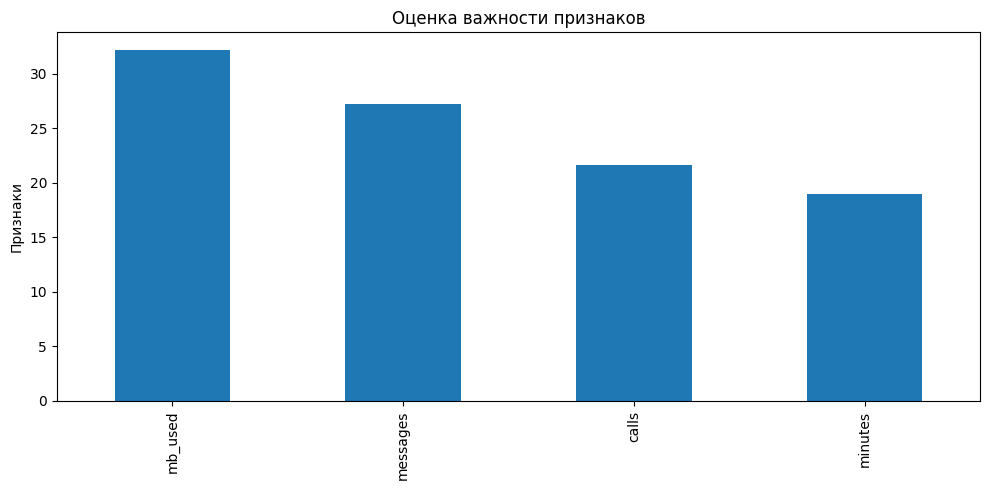

In [20]:
feature_imp = pd.Series(model.feature_importances_, index=f_test.columns).sort_values(ascending=False)
      
fig, ax = plt.subplots(figsize=(10,5))
feature_imp.plot.bar(ax=ax)
_ = ax.set_title('Оценка важности признаков')
_ = ax.set_ylabel('Признаки')
fig.tight_layout()

По графику важности признаков можно заметить, что все признаки имеют значимый вес для обучния

In [21]:
model = DummyClassifier(strategy="most_frequent").fit(f_train, t_train)
pred = model.predict(f_test)
print('accuracy:', accuracy_score(t_test, pred))


accuracy: 0.7002487562189055


# Отчет

**1) Подготовка**

- Размер данных 3214 на 5

**2) Анализ**

- Заметно преобладание тарифа **Смарт** примерно в два раза. Скорее всего это из за того, что при поиощи данного тарифа можно закрыт базовые портебности в связи
- Заметно, что чаще всего совершаю наибольшее кол-во звонков в диапазоне от 20 до 100 раз в месяц
- Заметно, что больше всего люди разговаривают от 170 до 750 минут в месяц
- Клиенты почти не пользуются сообщениями.
- Чаще всего клиентам достаточно в районе от 10000 до 25000 мегабайт в месяц

**3) Обучение модели**

- По результатам обучения моделей для проверки была выбрана модель CatBoostClassifier. При параметрах iterations: 3000, max_depth: 5 она показала наилучшую метрику **accuracy: 0.82**

**4) Тестирование лучшей модели**
- На тестовой выборке модель показала значение метрики **accuracy : 0.79**
- По графику важности признаков можно заметить, что все признаки имеют значимый вес для обучния
- Была сделана проверка модели на адекватность при помощи константной модели. Показатели константной модели составил **accuracy: 0.7**. По результатам модель проходит проверку на адекватность